# 기본 신경망 학습

Pytorch를 사용하여 신경망을 학습하는 것에 아직 미숙함을 가지고 계실 분들을 위해 만들어본 자료입니다.

본 자료는 아래 분들의 자료를 참고하여 만들었습니다.

Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST 데이터 학습을 위한 신경망 학습

torch와 관련된 library의 import

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model


from torch.autograd import Variable 
from torch.utils import data

데이터 분석을 위한 library의 import

In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Confusion Matrix (오차행렬)

### Confusion matrix란?
- Training을 통한 Prediction 성능을 예측 value와 실제 value를 비교하기 위한 표

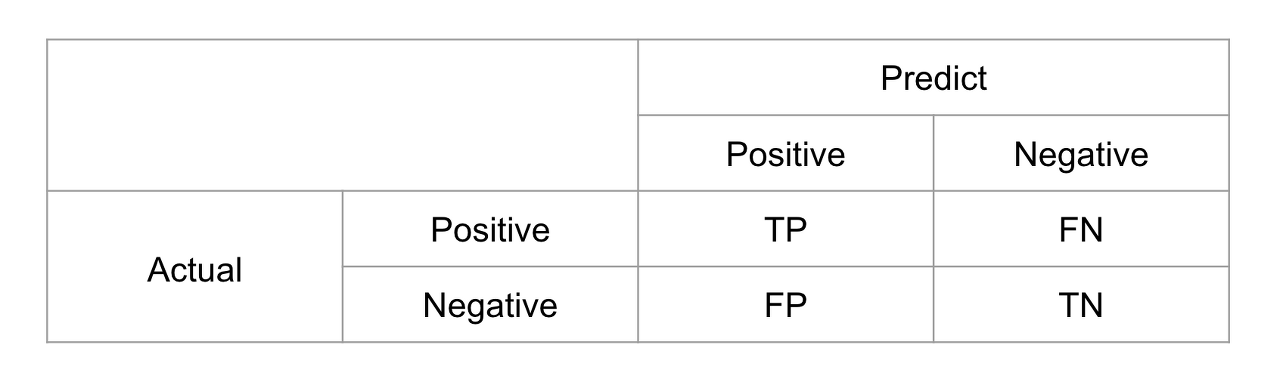

https://shinminyong.tistory.com/m/28 의 설명을 빌려와 설명하겠습니다.

### 자세한 설명

먼저 표 내부에 있는 단어들에 대한 설명을 드리겠습니다.(설명의 편의성을 위해서 환자다 / 환자가 아니다 로 설명드리겠습니다.)

Actual(Positive) : 실제 환자
Actual(Negative) : 실제 환자가 아님
Predict(Positive) : 실제 환자로 예측
Predict(Negative) : 환자가 아닌 것으로 예측
이번엔 각각의 교차된 지표에 대해서 설명드리겠습니다. 이 부분은 앞의 단어를 성공/실패 뒤의 단어를 긍정예측/부정예측 이라고 생각하시면 생각하시기 쉬울겁니다!

TP(True Positive) : 긍정예측을 성공 즉, 환자라고 예측해서 실제 환자임을 맞춤
TN(True Negative) : 부정예측을 성공 즉, 비환자라고 예측하여 실제 비환자임을 맞춤
FP(False Positive) : 긍정예측을 실패 즉, 환자라고 예측했지만 비환자임
FN(False Negative) : 부정예측을 실패 즉, 비환자라고 예측했지만 실제 환자임

In [3]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## DataLoader의 생성

MNIST Data의 경우 Pytorch의 torchvision에 이미 있는 데이터 셋입니다. 그리하여 torchvision으로부터 dataset을 받아오고, 받아온 데이터 셋을 원하는 batch size와 transform함수를 통해 data loader로 아래 처럼 만들어줍니다.

![mnist](./imgs/MnistExamples.png)

더욱 자세한 설명은 https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader 을 참고하시면 됩니다.

In [4]:
def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(), # convert data to tensor 
                                    download = True)  # whether to download the data
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download = True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [5]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


## Define Trainer

Trainer를 class로 만든 것입니다. 목적은 net, trainloader, testloader, optimizer, criterion을 모두 input으로 받아, Trainer 내에서 모델의 학습과 평가를 하기 위함입니다.

In [6]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Q1) waht if we dind't clear up the gradients?

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Q2) Why should we change the network into eval-mode?
                        # -
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
    def get_conf(self):
        self.net.eval()
        
        confusion = torch.zeros(10,10)
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = self.net(inputs)
            pred = torch.argmax(output, dim=1)
            
            for num in range(output.shape[0]):
                confusion[pred[num], labels[num]] += 1
        
        return confusion

## Let's create Model by yourself

![activation](./imgs/activation.png)

### (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [17]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() # Q3) Why do we need to call the constructor, nn.Module?
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = self.act(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [18]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [19]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [20]:
trainer.train(epoch = 4)

[1,   500] loss: 2.307
[1,  1000] loss: 2.288
[1,  1500] loss: 2.272
[2,   500] loss: 2.249
[2,  1000] loss: 2.235
[2,  1500] loss: 2.222
[3,   500] loss: 2.200
[3,  1000] loss: 2.186
[3,  1500] loss: 2.171
[4,   500] loss: 2.143
[4,  1000] loss: 2.128
[4,  1500] loss: 2.109
Finished Training


In [21]:
trainer.test()


Test set:  Accuracy: 5859/10000 (59%)



/home/sangmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


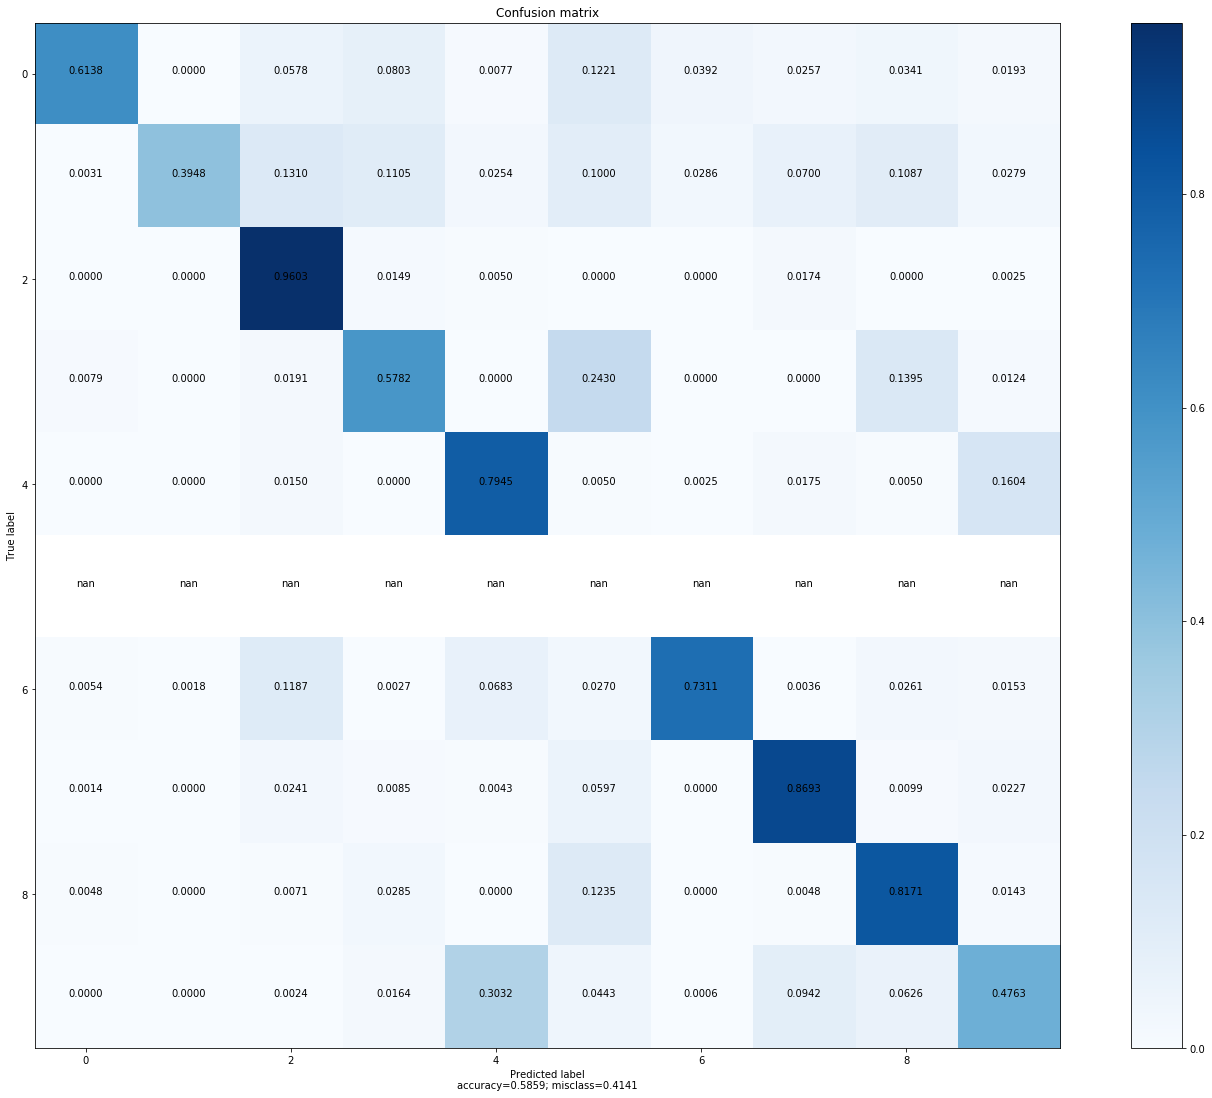

In [22]:
plot_confusion_matrix(trainer.get_conf().numpy())

### (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [23]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.act(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [24]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [25]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [26]:
trainer.train(epoch = 4)

[1,   500] loss: 2.291
[1,  1000] loss: 2.225
[1,  1500] loss: 2.142
[2,   500] loss: 1.946
[2,  1000] loss: 1.809
[2,  1500] loss: 1.654
[3,   500] loss: 1.395
[3,  1000] loss: 1.259
[3,  1500] loss: 1.134
[4,   500] loss: 0.973
[4,  1000] loss: 0.897
[4,  1500] loss: 0.847
Finished Training


In [27]:
trainer.test()


Test set:  Accuracy: 8395/10000 (84%)



### (3) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [28]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.act(x) 
        x = self.fc1(x) 
        return x

In [29]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [30]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [31]:
trainer.train(epoch = 4)

[1,   500] loss: 0.676
[1,  1000] loss: 0.324
[1,  1500] loss: 0.282
[2,   500] loss: 0.236
[2,  1000] loss: 0.223
[2,  1500] loss: 0.192
[3,   500] loss: 0.177
[3,  1000] loss: 0.172
[3,  1500] loss: 0.161
[4,   500] loss: 0.146
[4,  1000] loss: 0.141
[4,  1500] loss: 0.135
Finished Training


In [32]:
trainer.test()


Test set:  Accuracy: 9597/10000 (96%)



## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### (4) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [33]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = self.act(x) 
        x = self.fc1(x)   
        return x

In [34]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [35]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [36]:
trainer.train(epoch = 4)

[1,   500] loss: 0.716
[1,  1000] loss: 0.340
[1,  1500] loss: 0.275
[2,   500] loss: 0.217
[2,  1000] loss: 0.217
[2,  1500] loss: 0.203
[3,   500] loss: 0.174
[3,  1000] loss: 0.164
[3,  1500] loss: 0.177
[4,   500] loss: 0.142
[4,  1000] loss: 0.152
[4,  1500] loss: 0.144
Finished Training


In [37]:
trainer.test()


Test set:  Accuracy: 9639/10000 (96%)



In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

23920

### Convolution Operation

![Convolution](./imgs/Conv.png)



### (9) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [39]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = self.act(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [40]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [41]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [42]:
trainer.train(epoch = 4)

[1,   500] loss: 0.399
[1,  1000] loss: 0.176
[1,  1500] loss: 0.135
[2,   500] loss: 0.088
[2,  1000] loss: 0.090
[2,  1500] loss: 0.077
[3,   500] loss: 0.056
[3,  1000] loss: 0.065
[3,  1500] loss: 0.063
[4,   500] loss: 0.054
[4,  1000] loss: 0.053
[4,  1500] loss: 0.048
Finished Training


In [43]:
trainer.test()


Test set:  Accuracy: 9820/10000 (98%)



In [44]:
count_parameters(mnist_net)

11842

### (10) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)

In [45]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = self.act(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [46]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [47]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [48]:
trainer.train(epoch = 4)

[1,   500] loss: 0.560
[1,  1000] loss: 0.199
[1,  1500] loss: 0.149
[2,   500] loss: 0.111
[2,  1000] loss: 0.100
[2,  1500] loss: 0.095
[3,   500] loss: 0.083
[3,  1000] loss: 0.079
[3,  1500] loss: 0.076
[4,   500] loss: 0.065
[4,  1000] loss: 0.070
[4,  1500] loss: 0.069
Finished Training


In [49]:
trainer.test()


Test set:  Accuracy: 9765/10000 (98%)



In [50]:
count_parameters(mnist_net)

3202